In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
data_path = "Downloads/"
train_data = np.loadtxt(data_path + "mnist_train.csv", 
                        delimiter=",")
test_data = np.loadtxt(data_path + "mnist_test.csv", 
                       delimiter=",") 

In [13]:
print((train_data.shape))

(60000, 785)


In [50]:
fac = 255  *0.99 + 0.01

train_imgs = np.asfarray(train_data[0:59904, 1:]) 
test_imgs = np.asfarray(test_data[:1000, 1:]) 
train_labels = np.asfarray(train_data[0:59904, :1])
test_labels = np.asfarray(test_data[:1000, :1])

e = 1e-8
m = train_imgs.shape[1]
#mean = np.sum(train_imgs,axis = 0,keepdims = True)/m
#variance = np.sum(np.square(train_imgs-mean))/m
#train_imgs = (train_imgs-mean)/(np.sqrt(variance+e))

print(train_imgs.shape)
print(test_imgs.shape)
print(train_labels.shape)
print(test_labels.shape)
#print(train_imgs[:10][:10])

(59904, 784)
(1000, 784)
(59904, 1)
(1000, 1)


In [51]:
lr = np.arange(no_of_different_labels)
# transform labels into one hot representation
train_labels_one_hot = (lr==train_labels).astype(np.float)
test_labels_one_hot = (lr==test_labels).astype(np.float)
# we don't want zeroes and ones in the labels neither:
#train_labels_one_hot[train_labels_one_hot==0] = 0
#train_labels_one_hot[train_labels_one_hot==1] = 1
#test_labels_one_hot[test_labels_one_hot==0] = 0
#test_labels_one_hot[test_labels_one_hot==1] = 1


In [4]:
import tensorflow as tf
print(train_labels_one_hot.shape)

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(1024, 10)


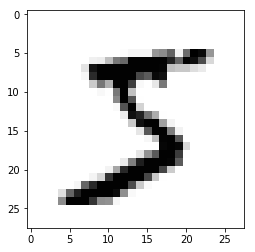

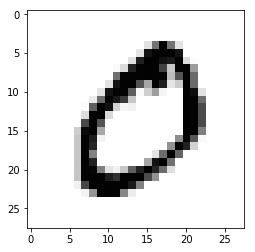

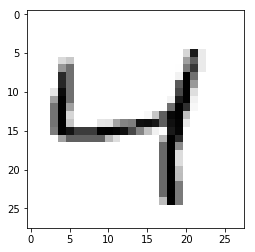

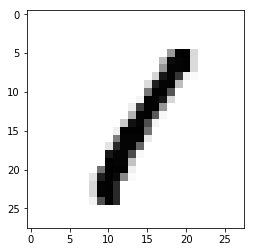

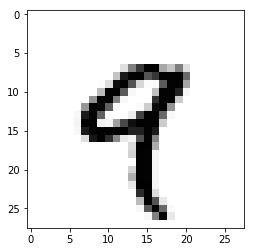

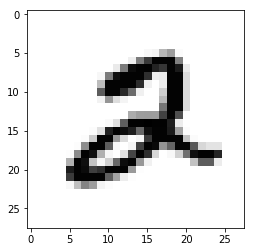

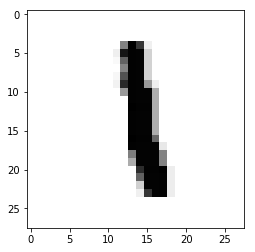

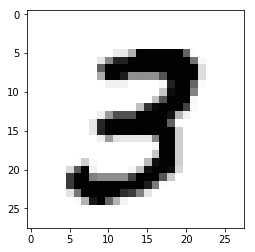

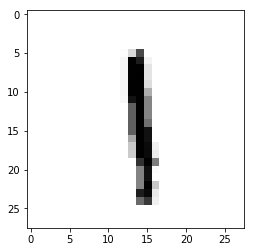

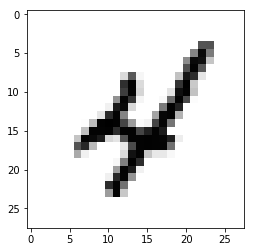

In [52]:
for i in range(10):
    img = train_imgs[i].reshape((28,28))
    plt.imshow(img, cmap="Greys")
    plt.show()

In [53]:
import pickle
with open("Downloads/pickled_mnist.pkl", "bw") as fh:
    data = (train_imgs, 
            test_imgs, 
            train_labels,
            test_labels,
            train_labels_one_hot,
            test_labels_one_hot)
    pickle.dump(data, fh)

In [54]:
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [55]:
train_imgs = train_imgs.T
test_imgs = test_imgs.T
train_labels_one_hot = train_labels_one_hot.T
test_labels_one_hot = test_labels_one_hot.T

In [56]:
layer_dims = [784,80,80,10]


In [57]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    parameters = {}
    L = len(layer_dims)            # number of layers in the network
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * np.sqrt(2/layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [58]:
import math
def random_mini_batches(X, Y, mini_batch_size = 64):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((10,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        end = m - mini_batch_size * math.floor(m / mini_batch_size)
        mini_batch_X = shuffled_X[:,num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches * mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches



In [59]:
def linear_forward(A, W, b):
    """

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [123]:
def softmax(Z):
    cache = Z
    S = np.exp(Z)
    #Sum = np.sum(S)
    Sum = np.sum(S,axis = 0,keepdims = True)
    return S/Sum,cache

In [124]:
z3 = [[1,2,3,4],[2,1,3,5]]
z3 = np.asfarray(z3)

z3 = z3.T
print(z3)

al,cache = softmax(z3)
print(al)

[[1. 2.]
 [2. 1.]
 [3. 3.]
 [4. 5.]]
[[0.0320586  0.0413707 ]
 [0.08714432 0.01521943]
 [0.23688282 0.11245721]
 [0.64391426 0.83095266]]


In [82]:
def relu(Z):
    """
    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

In [83]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    
    if activation == "softmax":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [84]:
def L_model_forward(X, parameters):
    """    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
   
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, 
                                             parameters['W' + str(l)], 
                                             parameters['b' + str(l)], 
                                             activation='relu')
        caches.append(cache)
        
        
    
    AL, cache = linear_activation_forward(A, 
                                          parameters['W' + str(L)], 
                                          parameters['b' + str(L)], 
                                          activation='softmax')
    caches.append(cache)
    
    
    
    assert(AL.shape == (10, X.shape[1]))
            
    return AL, caches

In [132]:
def compute_cost2(Z3,Y):
    AL,cache = softmax(Z3)
    log_prob = -np.log(AL)
    #print(log_prob)
    cost = np.multiply(log_prob,Y)
    total_cost = np.sum(np.amax(cost,axis=0))/len(Y[0])
    
    return total_cost

In [133]:
z3 = [[1,2,3,4],[2,1,3,5]]
y = [[0,1,0,0],[0,0,1,0]]
z3 = np.asfarray(z3)
z3 = z3.T
print(z3)

y = np.asfarray(y)
y = y.T
print(y)

cost = compute_cost2(z3,y)
print(cost)

[[1. 2.]
 [2. 1.]
 [3. 3.]
 [4. 5.]]
[[0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]]
2.312686075582504


In [17]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (10, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
   
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    
    return cost

In [137]:
def compute_cost_with_regularization2(AL, Y, parameters, lambd):
    m = Y.shape[1]
    
    cost = compute_cost2(AL,Y)
    
    L2_reg_cost = 0
    l = len(parameters) // 2
    for i in range(l):
        L2_reg_cost += np.sum(np.square(parameters["W"+str(i+1)]))
    
    L2_reg_cost *= ((lambd)/(2*m))
    
    total_cost = cost+L2_reg_cost
    return total_cost

In [18]:
def compute_cost_with_regularization(AL, Y, parameters, lambd):
    """    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    
    cost_tensor = compute_cost(AL, Y) # This gives you the cross-entropy part of the cost
    #print(cross_entropy_cost)
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    cross_entropy_cost = sess.run(cost_tensor)
    
    L2_regularization_cost = 0
    l = len(parameters) // 2
    for i in range(l):
        L2_regularization_cost+=np.sum(np.square(parameters["W"+str(i+1)]))
        
    L2_regularization_cost*=((lambd)/(2*m))
    
    cost = (cross_entropy_cost/m) + L2_regularization_cost
    #print(cost)
    return cost

In [138]:
def relu_backward(dA, cache):
    """

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    #print(Z.shape)
    #print(dZ.shape)
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [139]:
def linear_backward(dZ, cache,lambd):
    """
    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    ### START CODE HERE ### (≈ 3 lines of code)
    dW = np.dot(dZ, cache[0].T) / m+(lambd/m)*(W)
    db = (np.sum(dZ, axis=1, keepdims=True))/m
    
    #print(db.shape)
    #print(b.shape)
    dA_prev = np.dot(cache[1].T, dZ)
    ### END CODE HERE ###
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [140]:
def linear_activation_backward(dA, cache, activation,lambd):
    """    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "softmax" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        
    #elif activation == "softmax":
        #dZ = softmax_backward(dA, activation_cache)
    
    
    # Shorten the code
    dA_prev, dW, db = linear_backward(dZ, linear_cache,lambd)
    
    return dA_prev, dW, db

In [141]:
def L_model_backward(AL, Y, caches,lambd):
    """
    Backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "softmax" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    #dAL = dAL = - np.divide(Y, AL)
    
    # Lth layer (SOFTMAX -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[-1]
    #print(len(current_cache))
    dZ = AL-Y
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] =linear_backward(dZ,current_cache[0],lambd)
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], caches". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l+1)] , grads["db" + str(l+1)] 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)],current_cache,"relu",lambd)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [142]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

        s["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l + 1)])
    
    return v, s

In [143]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate,
                                beta1=0.9, beta2=0.999, epsilon=1e-8):
    """    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1, t))

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.power(grads['dW' + str(l + 1)], 2)
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.power(grads['db' + str(l + 1)], 2)

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2, t))

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v_corrected["dW" + str(l + 1)] / np.sqrt(s_corrected["dW" + str(l + 1)] + epsilon)
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v_corrected["db" + str(l + 1)] / np.sqrt(s_corrected["db" + str(l + 1)] + epsilon)

    return parameters, v, s

In [144]:
def update_parameters_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters to be updated:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients to update each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for l in range(L):
        ### START CODE HERE ### (approx. 2 lines)
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
        ### END CODE HERE ###
        
    return parameters

In [205]:
def model(X, Y, layers_dims, learning_rate, mini_batch_size=64,
          beta1=0.9, beta2=0.999, epsilon=1e-8, num_epochs=15, print_cost=True,lambd=0.1):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    m = X.shape[1]
    # Initialize parameters
    parameters = initialize_parameters_deep(layers_dims)

    # Initialize the optimizer
    # optimizer == "adam":
    v, s = initialize_adam(parameters)
    al = None
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        epoch_cost = 0
        minibatches = random_mini_batches(X, Y, mini_batch_size)
        num_mini_batches = int(m/mini_batch_size)
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
            
            # Forward propagation
            al, caches = L_model_forward(minibatch_X, parameters)

            # Compute cost
            last_cache = caches[-1]
            linear_c,act_c = last_cache
            mini_batch_cost = compute_cost_with_regularization2(act_c, minibatch_Y,parameters,lambd)
            
            #cost_tensor = compute_cost(al,minibatch_Y)
            #init = tf.global_variables_initializer()
            #sess = tf.Session()
            #sess.run(init)

            #mini_batch_cost = sess.run(cost_tensor)
            
            epoch_cost += (mini_batch_cost/num_mini_batches)
            # Backward propagation
            grads = L_model_backward(al, minibatch_Y, caches,lambd)

            # Update parameters
            # optimizer == "adam":
            t =  t+1 # Adam counter
            #print(epoch_cost)
            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,t, learning_rate, beta1, beta2,  epsilon)
            #parameters = update_parameters_gd(parameters,grads,learning_rate)
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1 == 0:
            print("Cost after epoch %i:%f " % (i ,epoch_cost))
        if print_cost and i % 1 == 0:
            costs.append(epoch_cost)
            
    
    #print(al)
   
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 1)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after epoch 0:6.219377 
Cost after epoch 1:1.366700 
Cost after epoch 2:0.872693 
Cost after epoch 3:0.644699 
Cost after epoch 4:0.534012 
Cost after epoch 5:0.464218 
Cost after epoch 6:0.403237 
Cost after epoch 7:0.364436 
Cost after epoch 8:0.333425 
Cost after epoch 9:0.301301 
Cost after epoch 10:0.277306 
Cost after epoch 11:0.255921 
Cost after epoch 12:0.239994 
Cost after epoch 13:0.222789 
Cost after epoch 14:0.211012 


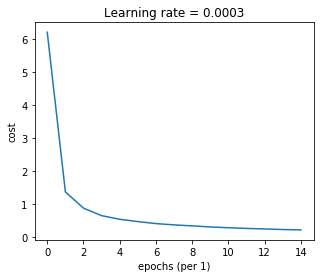

In [206]:

learning_rate=0.0003
mini_batch_size=64
parameters = model(train_imgs, train_labels_one_hot, layer_dims,learning_rate)

In [207]:
def predict(X,Y,parameters):
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((10,m))
    
    probs,caches = L_model_forward(X,parameters)
    
    indices = np.argmax(probs,axis=0)
    print(indices)
    for i in range(0,m):
        p[indices[i]][i]=1
    
    print("predictions: "+str(p))
    print("True labels: "+str(Y))
    
    return p,Y

In [208]:
X1 = test_imgs[:,5]
X1 = X1.reshape(X1.shape[0],1)
#img = X1.reshape((28,28))
#plt.imshow(img, cmap="Greys")
#plt.show()
p,y = predict(X1,test_labels_one_hot[:,5],parameters)


[1]
predictions: [[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
True labels: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [209]:
def accuracy(test_data,true_labels,parameters):
    m = test_data.shape[1]
    p = np.zeros((10,m))
    
    probs,caches = L_model_forward(test_data,parameters)
    indices = np.argmax(probs,axis=0)
    true_indices = np.argmax(true_labels,axis=0)
    
    cnt=0
    cnt = np.sum((indices==true_indices))
    return (cnt/m)
        

In [210]:
print("Train Accuracy: "+str(accuracy(train_imgs,train_labels_one_hot,parameters)))

Train Accuracy: 0.9800514155982906


In [211]:
print("Test Accuracy: "+str(accuracy(test_imgs,test_labels_one_hot,parameters)))

Test Accuracy: 0.957
